In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
!ls

MyDrive


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint

In [4]:
root="/gdrive/My Drive/DerinÖğrenme/duygu_tanima/"

data=pd.read_csv(root+ "data/fer2013.csv")
data.shape

(35887, 3)

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Eğitim Verisi için Ön İşleme

In [7]:
np.unique(data["Usage"].values.ravel())

print('ör sayısı: %d' %len(data[data.Usage =="Training"]))

ör sayısı: 28709


In [8]:
train_data = data[data.Usage=="Training"]

In [9]:
train_pixels=train_data.pixels.str.split(" ").tolist()

train_pixels=pd.DataFrame(train_pixels,dtype=int)
train_images=train_pixels.values
train_images=train_images.astype(np.float)

print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [10]:
def show(img):
    show_image=img.reshape(48, 48)
    
    plt.axis('off')
    plt.imshow(show_image,cmap='gray')

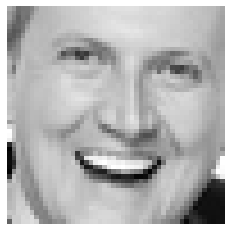

In [11]:
show(train_images[156]) 

In [12]:
 train_labels_flat = train_data["emotion"].values.ravel()
 train_labels_count = np.unique(train_labels_flat).shape[0]

 print("ifade sayısı : %d"%train_labels_count)

ifade sayısı : 7


In [13]:
def dense_to_one_hot(labels_dense,num_classes):
  num_labels=labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot= np.zeros((num_labels,num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [14]:
y_train = dense_to_one_hot(train_labels_flat,train_labels_count) 

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


Test Verisi İçin Önişleme

In [15]:
np.unique(data["Usage"].values.ravel())

print('test ör sayısı: %d' %len(data[data.Usage =="PublicTest"]))

test ör sayısı: 3589


In [16]:
testdata = data[data.Usage=="PublicTest"]

In [17]:
test_pixels=testdata.pixels.str.split(" ").tolist()

test_pixels=pd.DataFrame(test_pixels,dtype=int)
test_images=test_pixels.values
test_images=test_images.astype(np.float)

print(test_images)
print(test_images.shape)

[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]
(3589, 2304)


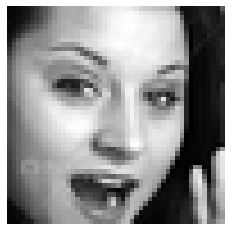

In [18]:
show(test_images[88])

In [19]:
test_labels_flat = testdata["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat,test_labels_count) 

y_test = y_test.astype(np.uint8)

print(y_test.shape)


(3589, 7)


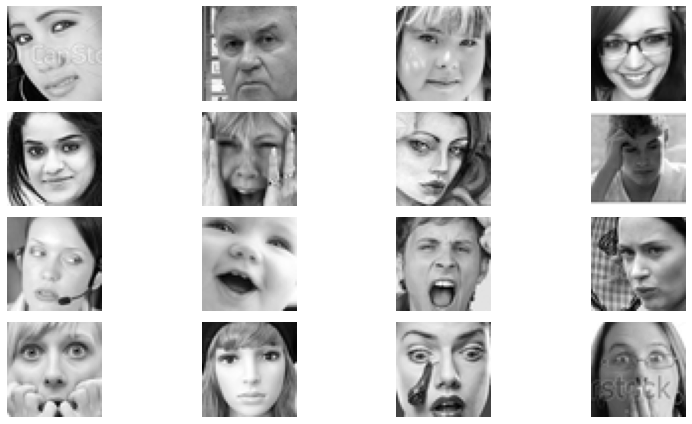

In [20]:
plt.figure(0,figsize=(12,6))

for i in range(1,17):
  plt.subplot(4,4,i)
  plt.axis("off")

  image=test_images[i].reshape(48,48)
  plt.imshow(image,cmap="gray")

plt.tight_layout()
plt.show()


In [32]:
model= Sequential()

In [33]:
#1.katman
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2.katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.6)) # %60 unutma işlemi

#3.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#5.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.6)) # %60 unutma işlemi

#tam baglanti katmani
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))  # %60 unutma işlemi

#cıkış katmanı
model.add(Dense(7))
model.add(Activation("softmax")) #sınıflama işlemi 

#optimazyon basarım metrikleri
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

model.summary() #modelin özeti

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

Eğitim ve test kümelerinin eleman ve duygu bilgileri


In [35]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [36]:
#duygu sınıfları sayısı
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [37]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 25
batchSize = 100 

# modeli çalıştır
hist = model.fit(x_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + "data/face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/25
288/288 - 16s - loss: 2.0155 - accuracy: 0.2431 - val_loss: 1.6527 - val_accuracy: 0.3522

Epoch 00001: val_loss improved from inf to 1.65268, saving model to /gdrive/My Drive/DerinÖğrenme/duygu_tanima/data/face_model.h5
Epoch 2/25
288/288 - 10s - loss: 1.6738 - accuracy: 0.3409 - val_loss: 1.5069 - val_accuracy: 0.4232

Epoch 00002: val_loss improved from 1.65268 to 1.50695, saving model to /gdrive/My Drive/DerinÖğrenme/duygu_tanima/data/face_model.h5
Epoch 3/25
288/288 - 10s - loss: 1.5568 - accuracy: 0.3927 - val_loss: 1.4283 - val_accuracy: 0.4542

Epoch 00003: val_loss improved from 1.50695 to 1.42833, saving model to /gdrive/My Drive/DerinÖğrenme/duygu_tanima/data/face_model.h5
Epoch 4/25
288/288 - 10s - loss: 1.4806 - accuracy: 0.4267 - val_loss: 1.4070 - val_accuracy: 0.4533

Epoch 00004: val_loss improved from 1.42833 to 1.40698, saving model to /gdrive/My Drive/DerinÖğrenme/duygu_tanima/data/face_model.h5
Epoch 5/25
288/288 - 10s - loss: 1.4158 - accuracy: 0.4534 -

Sonucların Analizi

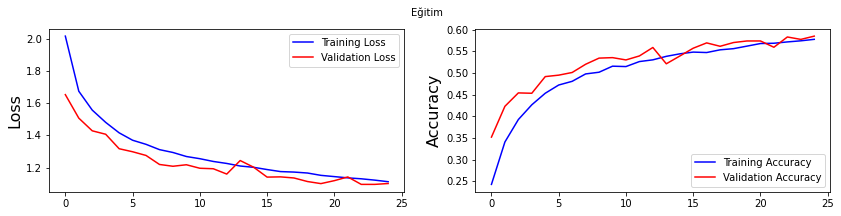

In [38]:

plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


Private Test Örnekleri

In [39]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [40]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [41]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [42]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.0650012493133545, 0.5943159461021423]


In [43]:
loss,acc = model.evaluate(x_test_private,  y_test_private, verbose=2)
print("Eğitim model, Oran: {:5.2f}%".format(100*acc))

113/113 - 1s - loss: 1.0650 - accuracy: 0.5943
Eğitim model, Oran: 59.43%


Farklı görüntü sonucları


In [44]:
from keras.models import load_model
from PIL import Image
from keras_preprocessing import image

In [45]:
model_best=load_model(root+"data/face_model.h5")

In [48]:
image_path=root+"images/soso.jpg"

test_image_original=image.load_img(image_path)
test_image=image.load_img(image_path,target_size=(48,48), grayscale=True)
test_data=image.img_to_array(test_image)
test_data=np.expand_dims(test_data,axis=0)
test_data=np.vstack([test_data])

results=model_best.predict(test_data,batch_size=1)



/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


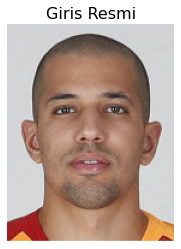

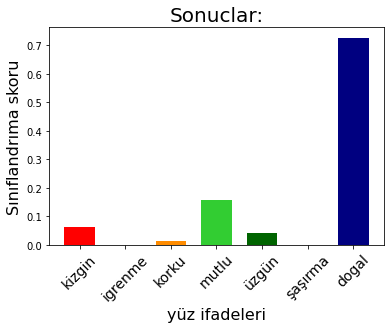

Sınıflandırma sonucu en yüksek oranla : dogal


In [49]:
class_name=["kizgin","igrenme","korku","mutlu","üzgün","şaşırma","dogal"]

ind = 0.1+0.6*np.arange(len(class_name)) 

width = 0.4   
color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

plt.imshow(test_image_original)
plt.title("Giris Resmi",fontsize=16)
plt.axis("off")
plt.show()

for i in range(len(class_name)):
  plt.bar(ind[i],results[0][i],width,color=color_list[i])

plt.title("Sonuclar:",fontsize=20)
plt.xlabel("yüz ifadeleri",fontsize=16)
plt.ylabel("Sınıflandrıma skoru",fontsize=16)
plt.xticks(ind,class_name,rotation=45,fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla :",class_name[np.argmax(results)])
